### 1. Check if TF-GPU is active

In [1]:
import tensorflow as tf

tf.test.is_built_with_cuda()

True

In [2]:
tf.__version__

'2.2.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.compat.v1 import ConfigProto

session_conf = ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8)
session_conf.gpu_options.allow_growth = True
# session_conf.gpu_options.per_process_gpu_memory_fraction = 0.7


In [5]:
session_conf.gpu_options.per_process_gpu_memory_fraction

0.0

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True,)


### 2. Import libs

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix, precision_recall_fscore_support, auc, accuracy_score

In [8]:
image_dimensions = {'height':256, 'width':256, 'channels':3}

### 3.  Create Keras model skeleton

In [9]:
class Meso4():
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)
        
    def fit_generator(train_generator, steps_per_epoch, validation_data, validation_steps, epochs):
        self.model.fit_generator(train_generator, steps_per_epoch, validation_data, validation_steps, epochs)
        

### 4. Load weights

In [10]:
meso = Meso4()
meso.load('./weights/Meso4_DF.h5')

In [11]:
type(meso.model)

tensorflow.python.keras.engine.training.Model

### 5. Load data and train model

In [12]:
batch_size = 24
nb_epochs = 10

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',shuffle=True) # set as training data

validation_generator = train_datagen.flow_from_directory(
    './data/', # same directory as training data
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary',
    subset='validation') # set as validation data

steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

#meso.model.fit_generator(train_generator,steps_per_epoch, validation_generator, validation_steps, nb_epochs)
meso.model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    class_weight={0:1,1:5})

Found 898 images belonging to 2 classes.
Found 223 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
37/37 [==============================] - 11s 301ms/step - loss: 0.5019 - accuracy: 0.5355 - val_loss: 0.3371 - val_accuracy: 0.5556
Epoch 2/10
37/37 [==============================] - 11s 299ms/step - loss: 0.4214 - accuracy: 0.5315 - val_loss: 0.3464 - val_accuracy: 0.1111
Epoch 3/10
37/37 [==============================] - 11s 297ms/step - loss: 0.4026 - accuracy: 0.5126 - val_loss: 0.3180 - val_accuracy: 0.3333
Epoch 4/10
37/37 [==============================] - 11s 299ms/step - loss: 0.3976 - accuracy: 0.5767 - val_loss: 0.2387 - val_accuracy: 0.5556
Epoch 5/10
37/37 [==============================] - 11s 295ms/step - loss: 0.3770 - accuracy: 0.5789 - val_loss: 0.3479 - val_accuracy: 0.1111
Epoch 6/10
37/37 [==============================] - 11s 291ms/step - loss: 0.3691 - accuracy: 0.5698 - val_loss: 0.1906 - val_a

### 6. Tests with a single face

Predicted likelihood: 0.1292
Actual label: 0

Correct prediction: True


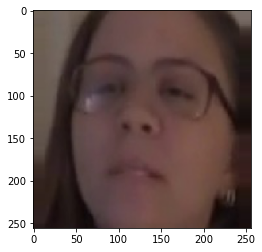

In [14]:


X, y = validation_generator.next()


print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")


plt.imshow(np.squeeze(X));

### 7. Tests with the validation set

In [15]:

correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []



In [16]:
predicts = []
for i in range(len(validation_generator.labels)):
    

    X, y = validation_generator.next()
    pred = meso.predict(X)[0][0]
    predicts.append(pred)
    

    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        

    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(validation_generator.labels)-1:
        print("All", len(validation_generator.labels), "predictions completed")

0  predictions completed.
All 223 predictions completed


In [17]:
len(predicts)

223

### 8. Results

In [18]:
predicts = [round(x) for x in predicts]
print(classification_report(validation_generator.labels, predicts,target_names=['fake','real']))

              precision    recall  f1-score   support

        fake       0.81      0.77      0.79       183
        real       0.14      0.17      0.16        40

    accuracy                           0.66       223
   macro avg       0.48      0.47      0.47       223
weighted avg       0.69      0.66      0.68       223



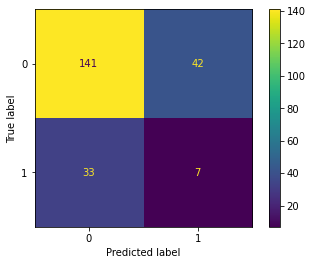

In [19]:
cm = confusion_matrix(validation_generator.labels, predicts)
fig, ax = plt.subplots()
display_labels = ['0','1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)


disp = disp.plot(include_values=True,
                 cmap='viridis', ax=ax, xticks_rotation='horizontal')

plt.show()

In [20]:
len(validation_generator.labels), len(train_generator.labels)

(223, 898)

In [21]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

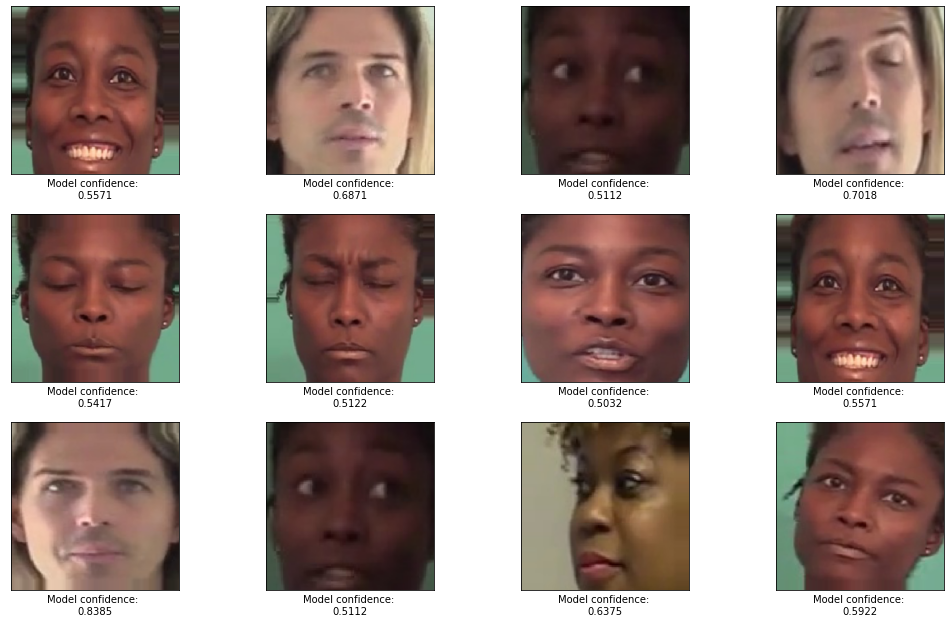

In [22]:
plotter(correct_real, correct_real_pred)

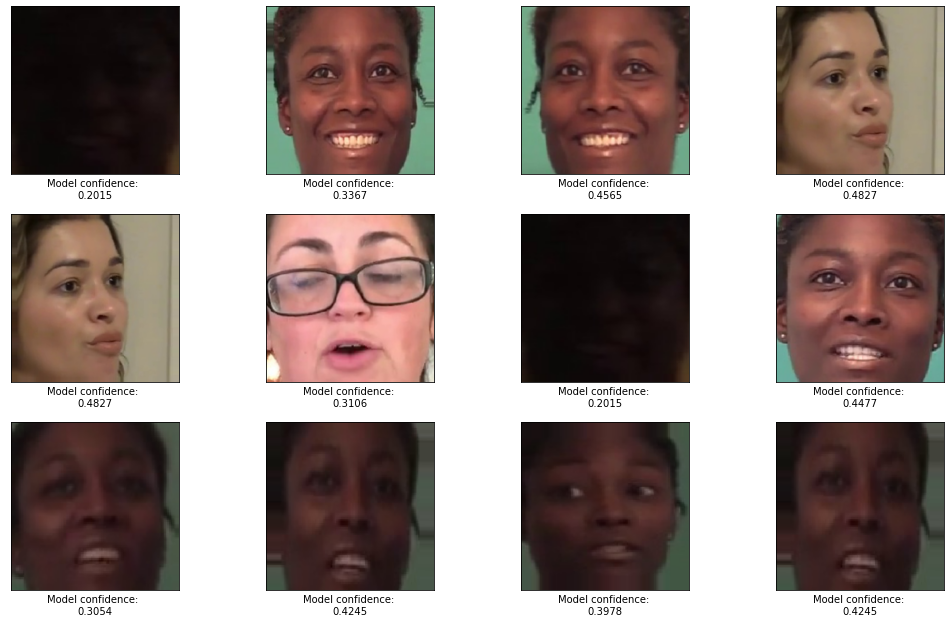

In [23]:
plotter(misclassified_real, misclassified_real_pred)

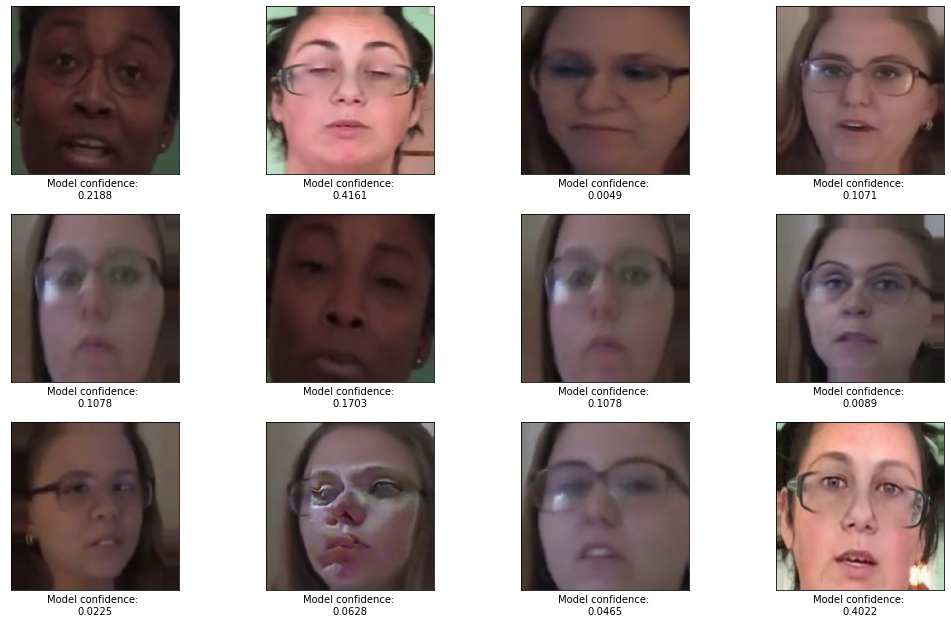

In [27]:
plotter(correct_deepfake, correct_deepfake_pred)

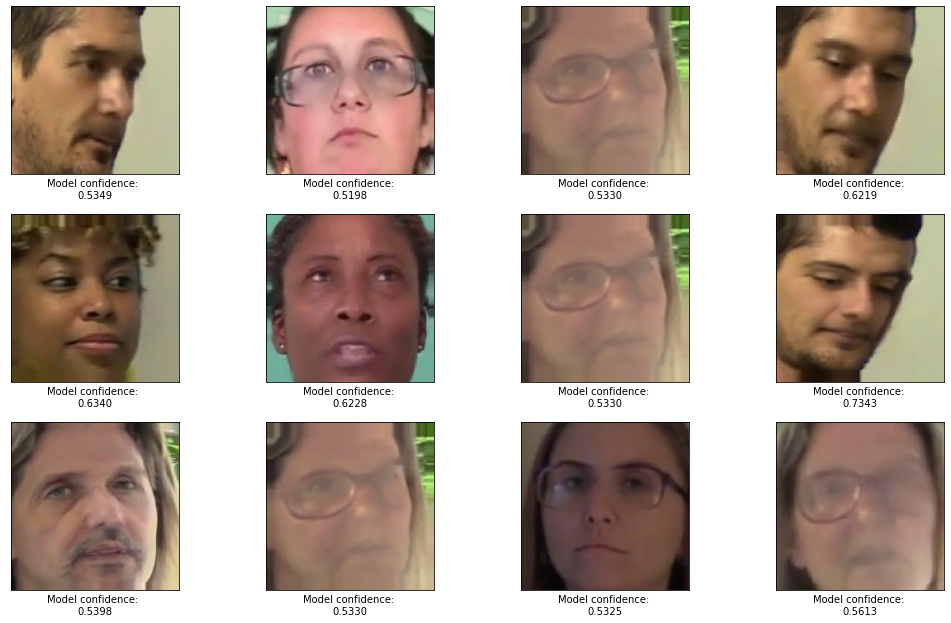

In [25]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)